In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
import scipy.stats

In [2]:
mpl.rcParams["figure.dpi"] = 250
mpl.rcParams["figure.figsize"] = (27, 6)

## Load Data into DF

In [3]:
parent_dir = ""
df_orig = pd.read_csv(os.path.join(parent_dir, "refisco-v0.csv"))

In [4]:
# load the data CSV (anonymized and filtered)
df = df_orig.copy()
df.head()

,id,indication,impression_original,impression_edited,score,annotator,source
0,p15002877s53670169,___-year-old female with shortness of breath.,Soft tissue in association with the right uppe...,[delete],Urgent error,0,CXRRepair
1,p15002877s53670169,___-year-old female with shortness of breath.,Pneumomediastinum is comparable in size to the...,pneumomediastinum,Not actionable,0,CXRRepair
2,p15002877s53670169,___-year-old female with shortness of breath.,Small right apical air collection could be ple...,small right upper-zone extrathoracic air colle...,Not actionable,0,CXRRepair
3,p15002877s53670169,___-year-old female with shortness of breath.,NaN,"focus of haziness over left apex, ,may be extr...",Not actionable,0,CXRRepair
4,p17016980s57870951,"___ year old man with appendicitis, tachypnea ...",Extensive consolidation is present involving t...,[no edit],No error,0,Expert


### Create Severity Column

In [5]:
def create_severity_col(my_df):
  err_severity = {'No error':0, 'Not actionable':1, 'Actionable nonurgent error':2, 'Urgent error':3, 'Emergent error':4}
  severity_list = my_df.score.replace(err_severity)
  my_df['severity'] = severity_list

In [6]:
create_severity_col(df)

## Check basic demographic / distribution information


In [7]:
# get pivot table of average score per annotation (unit)
pivot = df.pivot_table(index = ['id'], columns = ['source'], values = ['annotator'], aggfunc = 'nunique')
pivot.head()

annotator            
source             CXRRepair Expert XREM
id                                      
p15002877s53670169       1.0    1.0  2.0
p17016980s57870951       1.0    1.0  2.0
p17066961s50068790       2.0    1.0  1.0
p17996251s57940323       2.0    1.0  1.0
p18003191s57353771       NaN    2.0  2.0

What is the average score or distribution for each annotator?


In [8]:
df.pivot_table(index=['annotator', 'source'], values=['severity'], aggfunc='mean')

severity
annotator source             
0         CXRRepair  1.466667
          Expert     0.745763
          XREM       1.500000
1         CXRRepair  1.951220
          Expert     0.793103
          XREM       1.300971
2         CXRRepair  2.613636
          Expert     2.533333
          XREM       2.450000
3         CXRRepair  0.918919
          Expert     0.416667
          XREM       0.463636

In [9]:
df.pivot_table(index=['annotator', 'source'], values=['severity'], aggfunc='median')

severity
annotator source             
0         CXRRepair       1.0
          Expert          0.0
          XREM            1.0
1         CXRRepair       2.0
          Expert          0.0
          XREM            1.0
2         CXRRepair       3.0
          Expert          3.0
          XREM            3.0
3         CXRRepair       1.0
          Expert          0.0
          XREM            0.0

## Aggregate Per Annotation: Severity

In [10]:
df.annotator.unique()

array([0, 2, 1, 3])

In [11]:
# compute helpful groupbys

## Total Severity groupby 
total_groupby = df.groupby(['id', 'source', 'annotator']).severity.sum().unstack(level='annotator').unstack(level='id')

## Number of Lines in Original Report (Excluding Annotation Inserts)
df_wo_insert = df.dropna(subset=['impression_original'])
no_insert_count_groupby = df_wo_insert.groupby(['id', 'source', 'annotator']).severity.count().unstack(level='annotator').unstack(level='id')

## Number of Lines (Including Inserts)
count_groupby = df.groupby(['id', 'source', 'annotator']).severity.count().unstack(level='annotator').unstack(level='id')

In [12]:
src_names = ['X-REM', 'CXR-RePaiR', 'Expert']
src_list = ['XREM','CXRRepair','Expert']

def plot_groupby(severity_groupby_source, max_y = 0.48, metric_name="Avg"):
  '''
  Given a pandas groupby object of some severity metric across reports, 
  plots a histogram of that metric across reports for each source 

  Args: 
    severity_groupby_source: data grouped by report via a line-aggregation method 
      e.g. max or average severity across lines in the report
    max_y: height of plot
    metric_name: name of metric to display in plot
  Returns:
    vals_list: list of lists, each sublist contains report scores for a source
  '''
  fig, axes = plt.subplots(1,3, figsize=(18,4))
  vals_list = []
  # for each source 
  for i, src in enumerate(src_list):
    src_name = src_names[i]
    # get values to plot 
    vals = severity_groupby_source.loc[src].dropna()
    # create histogram
    freq, bins, patch = axes[i].hist(vals, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], rwidth=0.7, density=True)
    axes[i].set_title(f"{src_name}: Distr. of {metric_name} Error Severity (N={len(vals)})")
    axes[i].set_ylim([0, max_y])
    axes[i].set_xlabel("Error Severity across Reports")
    # print out the PMF and CDF 
    print(src)
    print([round(x,2) for x in freq])
    print([round(x,2) for x in freq.cumsum()])
    print(f"mean {round(vals.mean(),2)}, median {round(vals.median(),2)}")
    vals_list.append(vals)
  return vals_list 

XREM
[0.18, 0.18, 0.13, 0.39, 0.13]
[0.18, 0.36, 0.48, 0.87, 1.0]
mean 2.11, median 3.0
CXRRepair
[0.1, 0.23, 0.12, 0.41, 0.14]
[0.1, 0.33, 0.45, 0.86, 1.0]
mean 2.26, median 3.0
Expert
[0.34, 0.15, 0.15, 0.3, 0.06]
[0.34, 0.49, 0.64, 0.94, 1.0]
mean 1.58, median 2.0


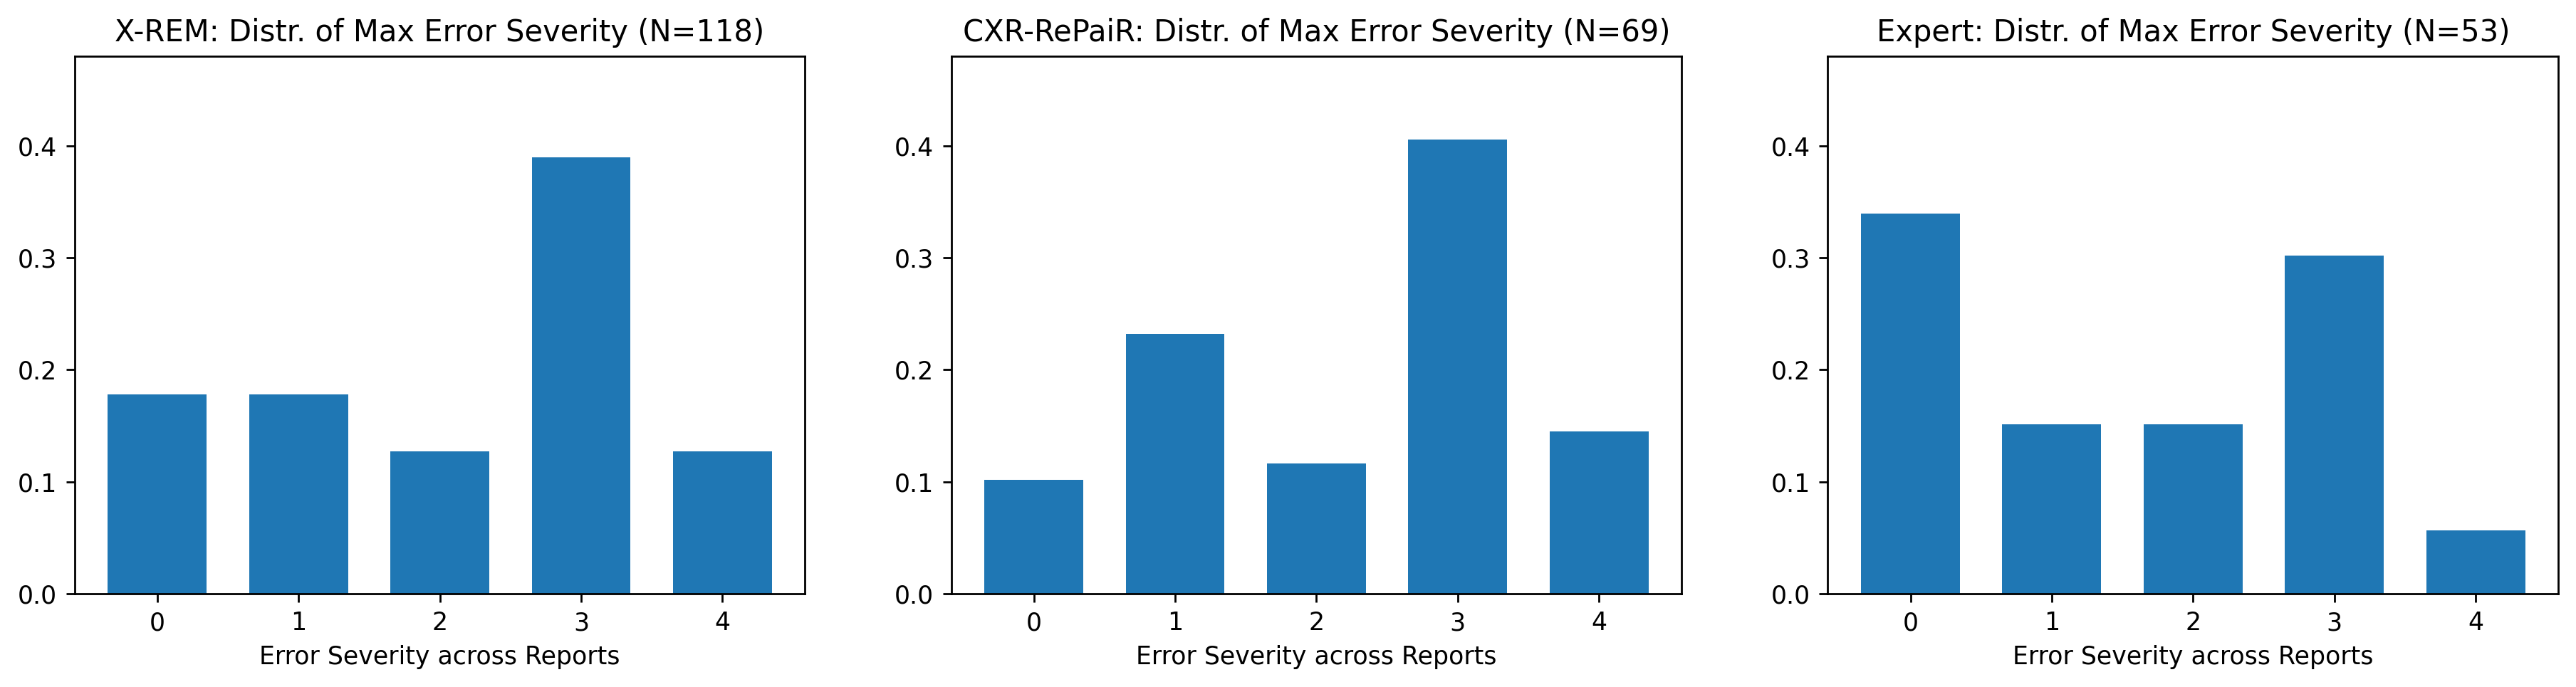

In [13]:
## Max Severity: Collapse severity per line to severity per report by worst-line severity
max_groupby = df.groupby(['id', 'source', 'annotator']).severity.max().unstack(level='annotator').unstack(level='id')
vals_list = plot_groupby(max_groupby, metric_name="Max")

In [14]:
## mean of Max Severity for each study and source 
max_piv_groupby = df.groupby(['id', 'source', 'annotator']).severity.max()
max_pivot = max_piv_groupby.to_frame().pivot_table(index=['id'], columns=['source'], values=['severity'], aggfunc='mean')
max_pivot.head()

severity            
source             CXRRepair Expert XREM
id                                      
p15002877s53670169       3.0    1.0  2.0
p17016980s57870951       1.0    0.0  2.0
p17066961s50068790       1.5    0.0  3.0
p17996251s57940323       3.5    3.0  3.0
p18003191s57353771       NaN    1.5  2.5

In [15]:
## mean of Max Severity for each annotator and source 
max_per_annotator = max_piv_groupby.to_frame().pivot_table(index=['annotator'], columns=['source'], values=['severity'], aggfunc='mean')
max_per_annotator

severity                    
source    CXRRepair    Expert      XREM
annotator                              
0          2.000000  1.500000  2.347826
1          2.733333  0.933333  2.366667
2          3.105263  3.000000  3.172414
3          1.222222  0.666667  0.888889

In [16]:
def paired_t_test(vals_list, a=None, b=None):
  '''
  Given list(s) of values, conduct a paired t-test on a paired sample 

  Args:
    vals_list: list of lists or list
    a,b: if val_list is a list of lists, a,b are indices of which lists to conduct test on
      a,b are None,None if val_list is a list 
  Returns:
    t-stat result of t-test 
  '''
  if a is None or b is None:
    diffs = vals_list 
  else:
    diffs = vals_list[a] - vals_list[b]
  print(f"mean: {np.mean(diffs)}, std: {np.std(diffs, ddof=1)}, sqrt n: {np.sqrt(len(diffs))}, se: {(np.std(diffs, ddof=1)/np.sqrt(len(diffs)))}")
  return np.mean(diffs)/(np.std(diffs, ddof=1)/np.sqrt(len(diffs)))

In [17]:
# PAIRED T-TEST on Max Severity 
# Null Hypothesis: Severity of CXR-Repair (Baseline) == Severity of X-REM (our method)
# Alternate Hypothesis: Severity of CXR-Repair > Severity of X-REM (meaning X-REM is better)
# Alternate Hypothesis (re-written): Severity of CXR-Repair - Severity of X-REM > 0

pairs = max_pivot[('severity','CXRRepair')] - max_pivot[('severity','XREM')]
valid_pairs = pairs.dropna()

print(f"Mean diff: {pairs.mean():.3f} \nSample size: {len(valid_pairs)}")
print(f"baseline, x-rem (>, =, <): {len(valid_pairs[valid_pairs > 0]), len(valid_pairs[valid_pairs == 0]), len(valid_pairs[valid_pairs < 0])}")

tstat = paired_t_test(valid_pairs)
pval = scipy.stats.t.sf(abs(tstat), df=len(valid_pairs)-1) 
print(f"t-stat: {tstat} \np-value: {pval}")

Mean diff: 0.408 
Sample size: 40
baseline, x-rem (>, =, <): (23, 2, 15)
mean: 0.4083333333333333, std: 1.7050912533750746, sqrt n: 6.324555320336759, se: 0.269598598954825
t-stat: 1.514597386323047 
p-value: 0.06896886454491945


XREM
[0.24, 0.23, 0.21, 0.23, 0.09]
[0.24, 0.47, 0.68, 0.91, 1.0]
mean 1.76, median 1.5
CXRRepair
[0.11, 0.23, 0.18, 0.31, 0.18]
[0.11, 0.34, 0.52, 0.82, 1.0]
mean 2.42, median 2.5
Expert
[0.35, 0.21, 0.13, 0.25, 0.06]
[0.35, 0.56, 0.69, 0.94, 1.0]
mean 1.47, median 1.0


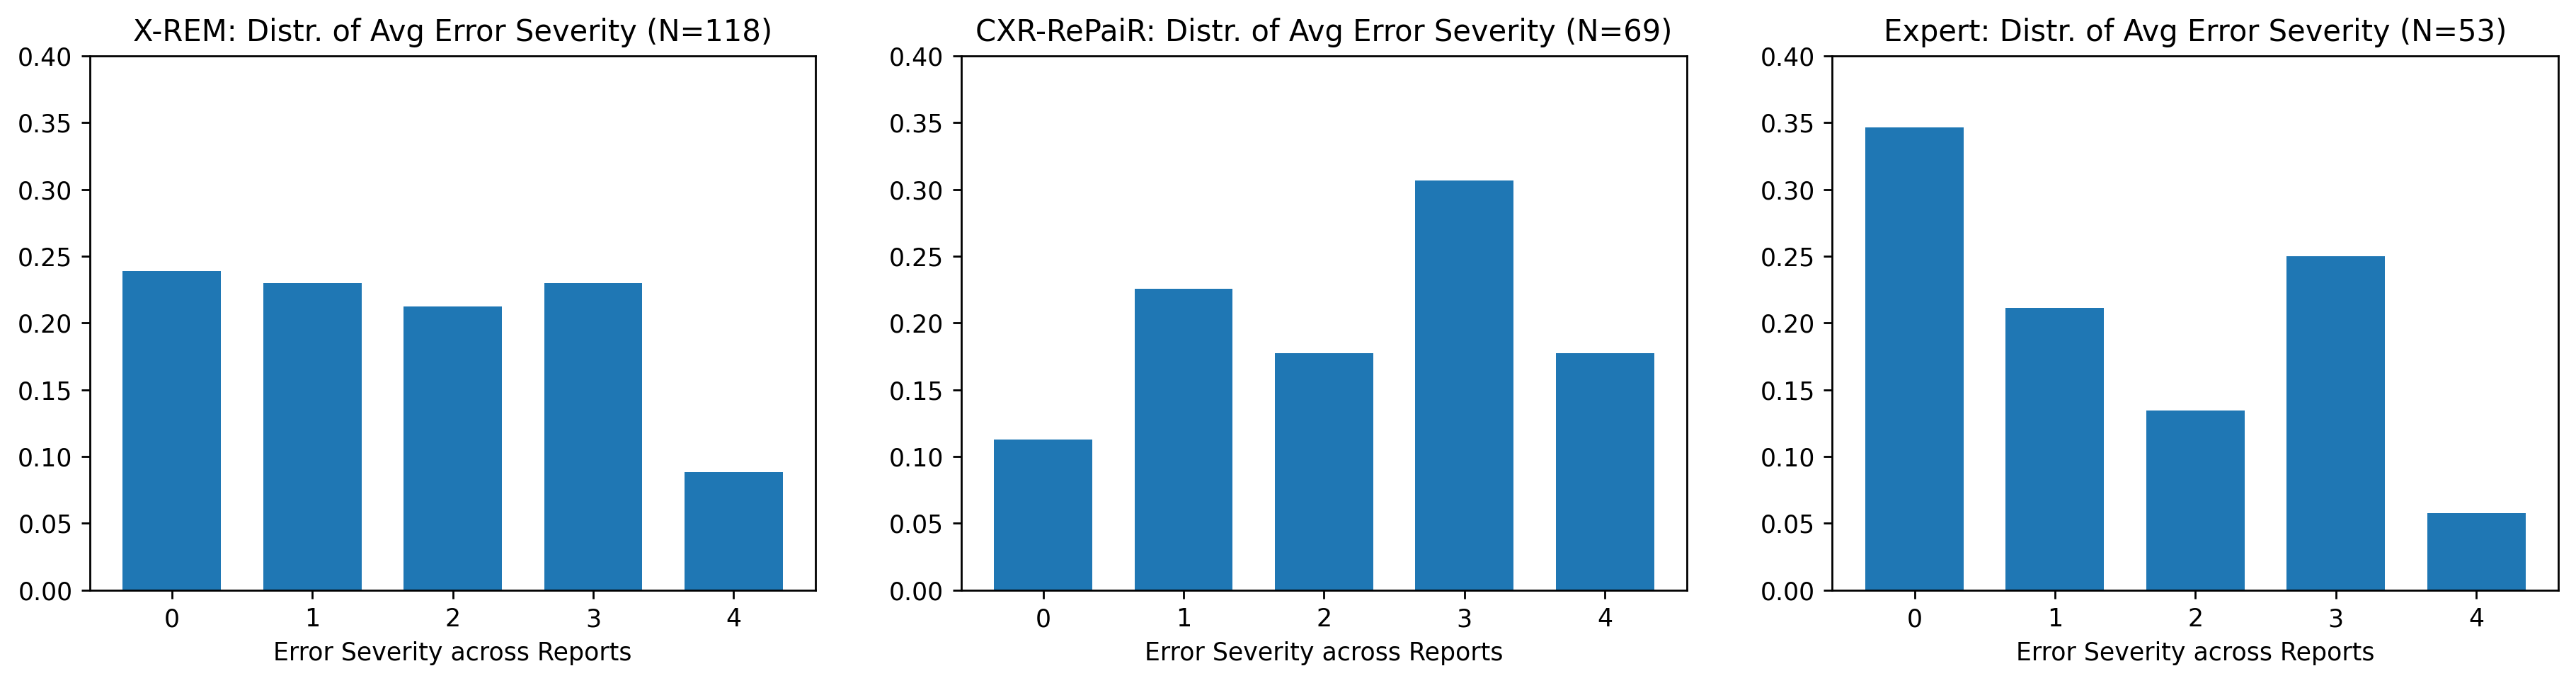

In [18]:
## Average Severity: Collapse severity per line to severity per report by average
# compute avg groupby using total / original count 
avg_groupby = total_groupby/no_insert_count_groupby
vals_list = plot_groupby(avg_groupby, max_y = 0.4)

In [19]:
avg_piv_groupby = df.groupby(['id', 'source', 'annotator']).severity.sum()/df_wo_insert.groupby(['id', 'source', 'annotator']).severity.count()
avg_pivot = avg_piv_groupby.to_frame().pivot_table(index=['id'], columns=['source'], values=['severity'], aggfunc='mean')
avg_pivot.head()

severity                    
source             CXRRepair    Expert      XREM
id                                              
p15002877s53670169      2.00  1.000000  1.333333
p17016980s57870951      1.00  0.000000  1.000000
p17066961s50068790      1.75  0.000000  3.500000
p17996251s57940323      3.00  0.833333  2.500000
p18003191s57353771       NaN  1.250000  1.750000

In [20]:
## mean of Max Severity for each annotator and source 
avg_per_annotator = avg_piv_groupby.to_frame().pivot_table(index=['annotator'], columns=['source'], values=['severity'], aggfunc='mean')
avg_per_annotator

severity                    
source    CXRRepair    Expert      XREM
annotator                              
0          2.558824  1.266667  2.246377
1          2.855556  1.133333  1.628399
2          3.350877  2.722222  3.033525
3          0.925926  0.500000  0.521682

In [21]:
# PAIRED T-TEST on Avg Severity 
# Null Hypothesis: Severity of CXR-Repair (Baseline) == Severity of X-REM (our method)
# Alternate Hypothesis: Severity of CXR-Repair > Severity of X-REM (meaning X-REM is better)
# Alternate Hypothesis (re-written): Severity of CXR-Repair - Severity of X-REM > 0

pairs = avg_pivot[('severity','CXRRepair')] - avg_pivot[('severity','XREM')]
valid_pairs = pairs.dropna()

print(f"Mean diff: {pairs.mean():.3f} \nSample size: {len(valid_pairs)}")
print(f"baseline, x-rem (>, =, <): {len(valid_pairs[valid_pairs > 0]), len(valid_pairs[valid_pairs == 0]), len(valid_pairs[valid_pairs < 0])}")

tstat = paired_t_test(valid_pairs)
pval = scipy.stats.t.sf(abs(tstat), df=len(valid_pairs)-1) 
print(f"t-stat: {tstat} \np-value: {pval}")

Mean diff: 0.691 
Sample size: 40
baseline, x-rem (>, =, <): (24, 3, 13)
mean: 0.6911309523809523, std: 1.9567777658205292, sqrt n: 6.324555320336759, se: 0.3093937307384226
t-stat: 2.2338233897999378 
p-value: 0.015650371269711683


## Examining Types of Edits Made

In [22]:
df['impression_edited'] = df['impression_edited'].fillna("[no edit]")

In [23]:
# loop through edits and categorize 
type_list = []
for i, row in df.iterrows():
  edit_line = row['impression_edited']
  if edit_line.strip() == '[delete]':
    type_list.append("Delete")
  elif edit_line.strip() == "[no edit]":
    type_list.append("None")
  elif pd.isnull(row['impression_original']):
    type_list.append("Insert")
  else:
    type_list.append("Edit")

In [24]:
df['edit_type'] = type_list
edit_type_counts = df.groupby(['source','edit_type']).id.count()
total_line_counts = df.groupby(['source']).id.count()

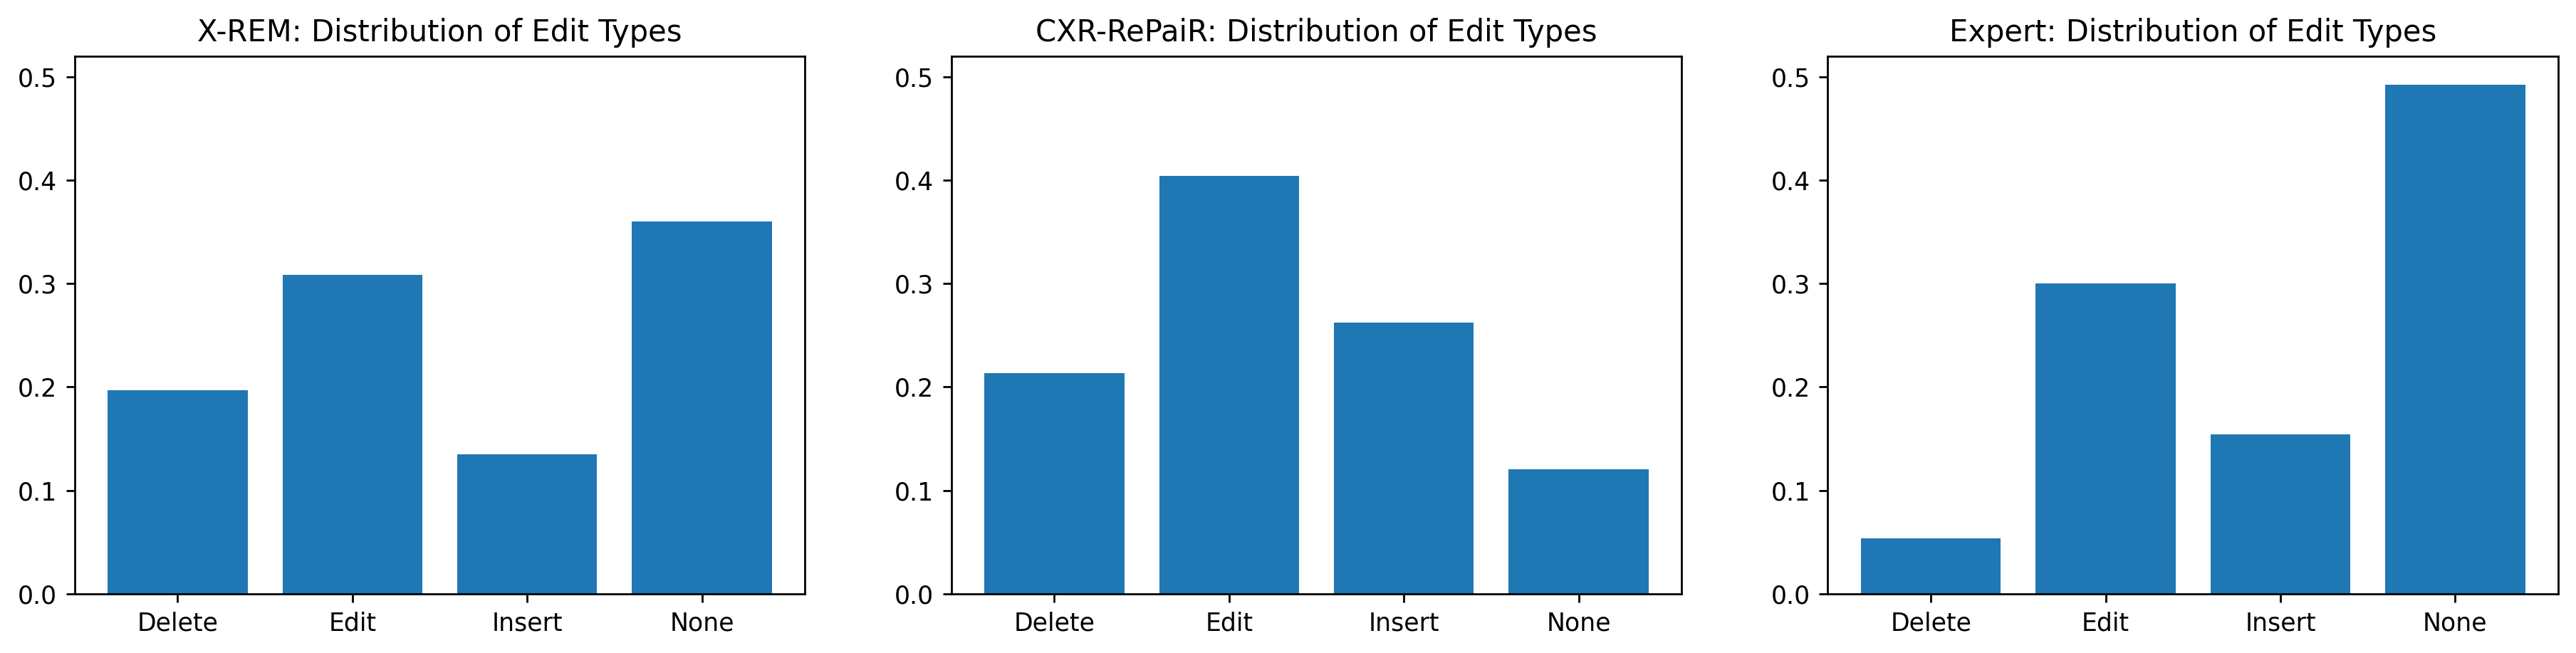

In [25]:
# Plot the frequency of each edit type, per source
fig, axes = plt.subplots(1,3, figsize=(18,4))
max_y = 0.52
for i in range(3):
  src = src_list[i]
  src_name = src_names[i]
  bars = edit_type_counts[src]/total_line_counts[src]
  axes[i].bar(bars.index, bars)
  axes[i].set_title(f"{src_name}: Distribution of Edit Types")
  axes[i].set_ylim([0, max_y])
